# Fitting with the distribution of phasances

Sometimes, spectra contain constant-phase contributions (straight lines in the Nyquist plot) like low-frequency (pseudo-)capacitance or Warburg diffusion, or high-frequency (pseudo-)inductance. We cannot easily fit these phenomena with the DRT, because the DRT inherently describes RC-type processes (semicircles in the Nyquist plot). 

Here, we show how the DRT is perturbed if we try to fit constant-phase processes directly with the DRT. A better approach is to incorporate a specific series element (like a CPE or inductor) to capture constant-phase contributions. Here, we use a constant-phase analog of the DRT, the distribution of phasances (DOP) (described in [this work](https://www.cell.com/joule/fulltext/S2542-4351(24)00203-4)) to treat constant-phase processes separately.

To illustrate, we use a measurement from the Li-ion conductor Li<sub>6</sub>PS<sub>5</sub>Cl (LPSCl) between ion-blocking electrodes. The spectrum contains a high-frequency semicircle, corresponding to Li-ion transport through LPSCl, and a low-frequency constant-phase tail due to the blocking electrodes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# The line below can be changed to %matplotlib inline or %matplotlib notebook,
# depending on which plotting backend you prefer
%matplotlib inline
from pathlib import Path

from hybdrt.models import DRT
import hybdrt.plotting as hplt
from hybdrt.dataload import read_eis

%load_ext autoreload
%autoreload 2

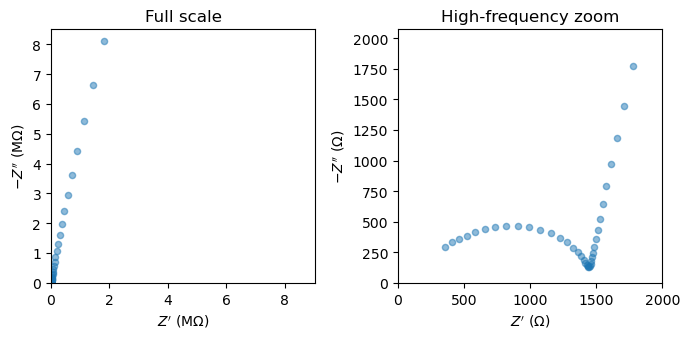

In [2]:
datadir = Path("./data")
file = datadir.joinpath("PEIS_LPSCl_IonBlocking_-25C.mpr")
zdata_lpscl = read_eis(file)
fz_lpscl = (zdata_lpscl.freq, zdata_lpscl.z)


fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
hplt.plot_nyquist(fz_lpscl, ax=axes[0])
hplt.plot_nyquist(fz_lpscl, ax=axes[1], scale_prefix="")
    
# Zoom in on the high-frequency semicircle
hplt.zoom_nyquist_x(axes[1], (0, 2e3), ymin=0)

axes[0].set_title("Full scale")
axes[1].set_title("High-frequency zoom")

fig.tight_layout()


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


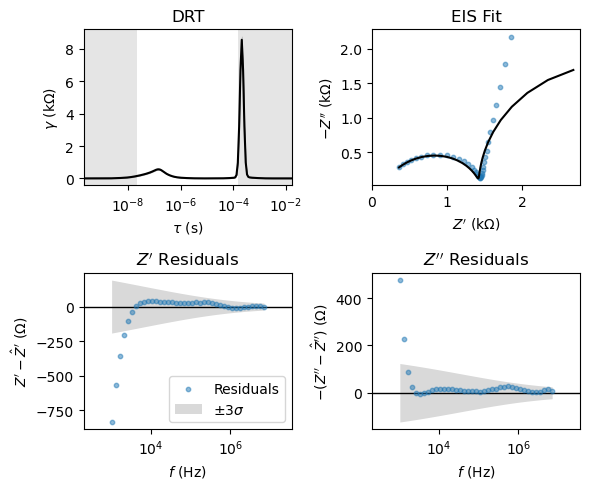

In [3]:
# Attempt a direct DRT fit
# Since we're interested in the semicircle (ion transport), let's limit the data to high frequencies
zdata_trimmed = zdata_lpscl.trim_freq(f_min=1e3)
fz_trimmed = (zdata_trimmed.freq, zdata_trimmed.z)

drt = DRT()
drt.fit_eis(*fz_trimmed)

axes = drt.plot_results()

Directly fitting the spectrum with the DRT does not work well. The DRT cannot capture the straight-line tail due to the blocking electrode, resulting in a large divergence of the fit from the data. The blocking electrode tail also creates a peak in the DRT near $\tau=10^{-4}$, which does not actually represent an RC process.

Next, we fit the spectrum again, but use the DOP to capture the blocking tail. The DOP is a 2nd distribution that is placed in series with the DRT to capture constant-phase processes.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')


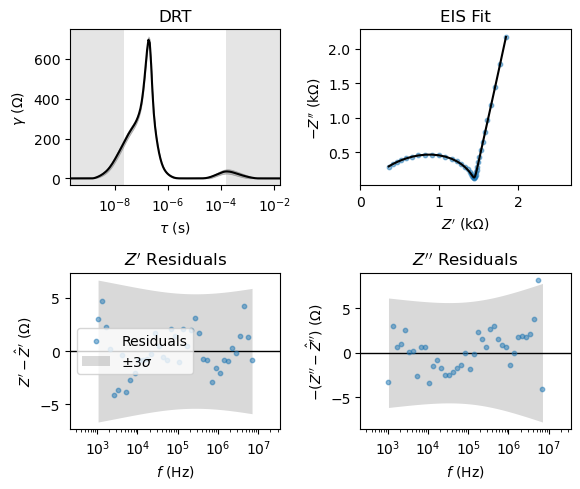

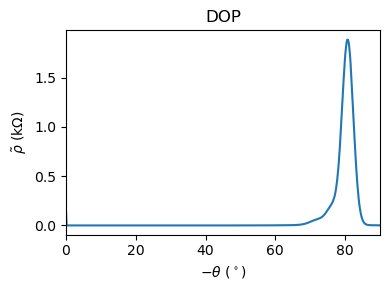

In [4]:
# Fit with the DOP included
# We can make a copy of the existing DRT instance to avoid recalculating integral lookup tables
dop = drt.copy()
dop.fit_dop = True
dop.fit_eis(*fz_trimmed)

# Plot the DRT and fit results
dop.plot_results()

# Plot the DOP component
ax = dop.plot_dop(normalize=True)
ax.set_xlim(0, 90)
ax.set_title("DOP")
ax.get_figure().tight_layout()

The DRT-DOP model yields a much better fit of the data. The DOP captures the blocking electrode process with a peak near $80^\circ$, indicating the phase angle of the low-frequency tail. Meanwhile, the DRT shows only a single peak near  $\tau=10^{-7}$ s, corresponding to the ion transport semicircle (slightly asymmetric, perhaps due to overlapping bulk and grain boundary processes). There is a small peak in the DRT near  $\tau=10^{-4}$ s that overlaps with the DOP contribution. Thus arises due to the fact that the low-frequency pseudo-capacitive tail is not perfectly straight. However, it is unclear whether there is truly another RC-type process at this time constant, or if this is just a measurement artifact.

This approach is similar to modeling the data using the DRT in series with a CPE. However, the DOP has the advantage that the phase angle of the CPE does not need to be specified *a priori*, and multiple phase angles from multiple constant-phase processes can be captured by the DOP.